In [1]:
# Librerias necesarias
import numpy as np  # numPy para operaciones numéricas
import matplotlib.pyplot as plt # Matplotlib para visualización
from skimage.io import imread # skimage para leer imágenes
from skimage.morphology import dilation, disk # skimage para operaciones morfológicas
import cv2 # OpenCV para procesamiento de imágenes

# Filtros Lineales y Contornos

En este tutorial estudiaremos la operación de cross-correlación, y cómo esta es empleada para la implementación de filtros lineales en imágenes. Utilizaremos la cross-correlación para reducir el ruido de una imagen a través de un filtro Gaussiano y para extraer los contornos de una imagen mediante el método de Canny.

## Cross - Correlación

Matemáticamente, la cross-correlación se define de la siguiente forma:

<div>
<img src="definicion.png" width="350"/>
</div>
donde $g(x,y)$ corresponde al valor del píxel en la coordenada (x, y) en la matriz resultante de la cross-correlación, $a$ y $b$ corresponden a la mitad de las dimensiones en $x$ y $y$ del filtro menos 1, y $w$ y $f$ son las funciones asociadas al filtro y la imagen respectivamente.

> **Nota**: Si denotamos a las dimensiones del filtro en los ejes $x$ y $y$ como $m$ y $n$ respectivamente, podemos expresar a $a$ y $b$ de la siguiente forma:

\begin{equation}
a = \frac{m-1}{2} \quad b = \frac{n-1}{2}
\end{equation}

> Note que esta definición está restringida a filtros con dimensiones impares iguales o mayores a 3.

En términos prácticos, podemos resumir la cross-correlación en los siguientes pasos:

1. Centre el filtro $w$ en cada píxel de la imagen $f$.
1. Multiplique cada elemento del filtro con el píxel en el que se sobrepone en la imagen.
1. Sume dichos productos, y asigne el valor obtenido al píxel central de la matriz resultante de la cross-correlación.

A continuación, se presenta un diagrama que resume este proceso con un ejemplo:

<img src="conv_ex.png"/>




En términos prácticos, al realizar una cross-correlación para el filtrado de una imagen se debe tomar una decisión con respecto a las multiplicaciones asociadas a los bordes de la imagen. Si se realiza la cross-correlación únicamente sobre los píxeles originales (como en el ejemplo anterior), la imagen resultante tendrá unas dimensiones menores a la imagen original en un factor de $2a$ y $2b$ para ambos ejes. Si se desea que la imagen resultante tenga las mismas dimensiones de la imagen original, se debe crear un contorno con intensidades ficticias (padding) de tal forma que se le pueda centrar el filtro en cada píxel de la frontera. Algunas de las alternativas para asignar las intensidades de este contorno es asignar un valor fijo en específico (como por ejemplo 0) o reflejar las intensidades de la imagen original.

A continuación, se presenta una función que implementa la cross-correlación entre dos matrices, asignando un contorno de ceros a la primera matriz de tal forma que la matriz resultante tenga sus mismas dimensiones originales:

In [2]:
def cross_correlation(f, w):
    # Obtener m, n, a y b a partir de su definición
    m, n = w.shape
    a, b = (m - 1)//2, (n - 1)//2
    
    # Crear una matriz correspondiente a f con un borde de ceros que permita obtener una matriz resultante
    # de la convolución de iguales dimensiones a f
    f_aug = np.block([[np.zeros((a, b)),           np.zeros((a, f.shape[1])),             np.zeros((a, b))],
                      [np.zeros((f.shape[0], b)),             f,                 np.zeros((f.shape[0], b))],
                      [np.zeros((a, b)),           np.zeros((a, f.shape[1])),             np.zeros((a, b))]])
    
    # Se crea un arreglo en el que se almacenarán los valores de g
    g = np.zeros(f.shape)
    
    # Para cada coordenada de g:
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            # Trasladamos x y y a las coordenadas de f con borde
            x_aug = x + a
            y_aug = y + b
            
            # La ventana que se sobrelapa al filtro tiene coordenadas (x-a:x+a, y-b:y+b) en el sistema de coordenadas
            # de f con su borde. Se extrae esta ventana
            f_window = f_aug[x_aug - a:x_aug + a + 1, y_aug - b: y_aug + b + 1]
            
            # Se multiplica cada punto de la ventana con el filtro w, se suman estos valores, y se asigna dicha suma
            # a la posición (x, y) de la matriz resultante.
            g[x, y] = np.sum(np.multiply(w, f_window))
    
    # Se retorna la matriz resultante de la cross-correlación
    return g

# Ejemplo de cross-correlación:

f = np.reshape(np.arange(1, 37), (6, 6))
w = np.ones((3,5))
g = cross_correlation(f, w)

print('Ejemplo:')

print('Se emplea la siguiente matriz como imagen:')
print(f)

print('Se emplea la siguiente matriz como filtro:')
print(w)

print('El resultado de la cross-correlación es:')
print(g)

Ejemplo:
Se emplea la siguiente matriz como imagen:
[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]
 [25 26 27 28 29 30]
 [31 32 33 34 35 36]]
Se emplea la siguiente matriz como filtro:
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
El resultado de la cross-correlación es:
[[ 30.  44.  60.  70.  60.  48.]
 [ 72. 102. 135. 150. 126.  99.]
 [126. 174. 225. 240. 198. 153.]
 [180. 246. 315. 330. 270. 207.]
 [234. 318. 405. 420. 342. 261.]
 [174. 236. 300. 310. 252. 192.]]


### **Ejercicio 1:** 
Modifique la anterior función para que se pueda ingresar como parámetro si se quiere adicionar un borde de un numero especifico en lugar de 0's. Esto ya que dependiendo de nuestro rango de valores aveces vamos a querer numeros diferentes de 0 para hacer el padding, en algunos casos incluso se querrá usar una versión reflejada de la imagen o repeticiones de esta.

In [7]:
# Ejecute su implementación en este recuadro
def cross_correlation_padding(f, w, num):
    # Obtener m, n, a y b a partir de su definición
    m, n = w.shape
    a, b = (m - 1)//2, (n - 1)//2
    
    # Crear una matriz correspondiente a f con un borde de ceros que permita obtener una matriz resultante
    # de la convolución de iguales dimensiones a f    
    f_aug = np.block([[np.full((a, b), num),           np.full((a, f.shape[1]), num),             np.full((a, b), num)],
                      [np.full((f.shape[0], b), num),             f,                 np.full((f.shape[0], b), num)],
                      [np.full((a, b), num),           np.full((a, f.shape[1]), num),             np.full((a, b), num)]])

    # Se crea un arreglo en el que se almacenarán los valores de g
    g = np.zeros(f.shape)
    
    # Para cada coordenada de g:
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            # Trasladamos x y y a las coordenadas de f con borde
            x_aug = x + a
            y_aug = y + b
            
            # La ventana que se sobrelapa al filtro tiene coordenadas (x-a:x+a, y-b:y+b) en el sistema de coordenadas
            # de f con su borde. Se extrae esta ventana
            f_window = f_aug[x_aug - a:x_aug + a + 1, y_aug - b: y_aug + b + 1]
            
            # Se multiplica cada punto de la ventana con el filtro w, se suman estos valores, y se asigna dicha suma
            # a la posición (x, y) de la matriz resultante.
            g[x, y] = np.sum(np.multiply(w, f_window))
    
    # Se retorna la matriz resultante de la cross-correlación
    return g

In [8]:
f = np.reshape(np.arange(1, 37), (6, 6))
w = np.ones((3,3))
g1 = cross_correlation_padding(f, w, 1)
g2 = cross_correlation_padding(f, w, 2)

print('El resultado de la cross-correlación con padding de 1s es:')
print(g1)
print('El resultado de la cross-correlación con padding de 2s es:')
print(g2)

assert(f.shape==g1.shape)
assert(f.shape==g2.shape)
assert(np.isclose(g1[0,0],23))
assert(np.isclose(g2[0,0],28))
assert(np.all(g1[1:-1,1:-1]==g2[1:-1,1:-1]))

El resultado de la cross-correlación con padding de 1s es:
[[ 23.  33.  39.  45.  51.  39.]
 [ 48.  72.  81.  90.  99.  72.]
 [ 84. 126. 135. 144. 153. 108.]
 [120. 180. 189. 198. 207. 144.]
 [156. 234. 243. 252. 261. 180.]
 [119. 177. 183. 189. 195. 135.]]
El resultado de la cross-correlación con padding de 2s es:
[[ 28.  36.  42.  48.  54.  44.]
 [ 51.  72.  81.  90.  99.  75.]
 [ 87. 126. 135. 144. 153. 111.]
 [123. 180. 189. 198. 207. 147.]
 [159. 234. 243. 252. 261. 183.]
 [124. 180. 186. 192. 198. 140.]]


## Filtro Gaussiano

Un filtro Gaussiano consiste en una versión discretizada de una distribución normal en dos dimensiones (el producto vectorial entre dos distribuciones normales de una dimensión), cuya media coincide con el elemento central de la matriz. Este filtro cuenta con la propiedad que asegura que la suma de todos sus elementos es igual a 1, por lo que al efectuar una cross-correlación con él se preserva el rango dinámico de intensidades de la imagen. Además, los pesos asignados a cada píxel son mayores a medida que se encuentran más cerca al píxel central. Esto permite reducir el ruido de la imagen al realizar una cross-correlación ponderando las intensidades de cada píxel con sus vecinos, pero a su vez preserva en mayor medida su correspondencia con la imagen original.

Los dos principales parámetros a tener en cuenta para la creación de un filtro Gaussiano son el tamaño de la matriz y la desviación estándar de la distribución ($\sigma$). A continuación, se presenta la implementación de una función que retorna un filtro Gaussiano a partir de un tamaño de ventana y una desviación estándar ingresadas como parámetro: 


In [9]:
def gaussian_kernel(size, sigma):
    a = int(size)//2
    # Se crea una malla de coordenadas asociada a la matriz que representa el filtro
    x, y = np.mgrid[-a:a+1, -a:a+1]
    # Se define un factor normalizador encargado de preservar el rango dinámico de la imágen
    normal = 1/(2.0 * np.pi * sigma**2)
    # Se aplica la distribución normal de dos dimensiones para definir las intensidades del filtro
    g = np.exp(-((x**2 + y**2)/(2.0 * sigma**2))) * normal
    # Se las mallas asociadas a las coordenadas del filtro y sus intensidades
    return x, y, g


Empleando esta función, a continuación se presenta una visualización tridimensional de este filtro para distintos valores de desviación estándar:

Text(0.5, 0, 'Intensidad')

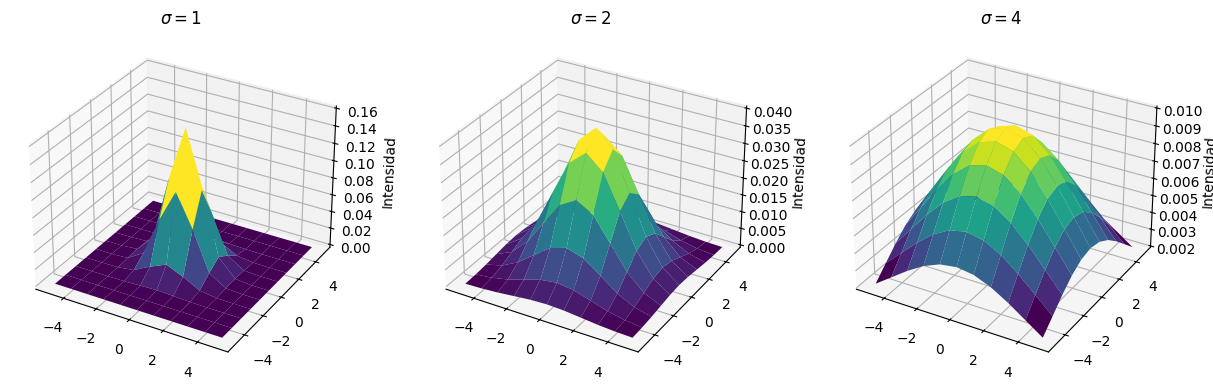

In [10]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(1, 3, 1, projection='3d')
x, y, g = gaussian_kernel(11, 1)
ax.plot_surface(x, y, g, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title(r"$\sigma = 1$")
ax.set_zlabel("Intensidad")

ax = fig.add_subplot(1, 3, 2, projection='3d')
x, y, g = gaussian_kernel(11, 2)
ax.plot_surface(x, y, g, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title(r"$\sigma = 2$")
ax.set_zlabel("Intensidad")

ax = fig.add_subplot(1, 3, 3, projection='3d')
x, y, g = gaussian_kernel(11, 4)
ax.plot_surface(x, y, g, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title(r"$\sigma = 4$")
ax.set_zlabel("Intensidad")


La representación discreta y en 2 dimensiones de los filtros Gaussianos con distintas combinaciones de desviaciones estándar y tamaños de ventana se muestra a continuación:

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
C:\Users\User\AppData\Local\Temp\ipykernel_13180\2561472248.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma$ fija ($\sigma = 3$)" + "\nsize=3")
C:\Users\User\AppData\Local\Temp\ipykernel_13180\2561472248.py:34: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma$ fija ($\sigma = 3$)" + "\nsize=7")
C:\Users\User\AppData\Local\Temp\ipykernel_13180\2561472248.py:41: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma$ fija ($\sigma = 3$)" + "\nsize=33")


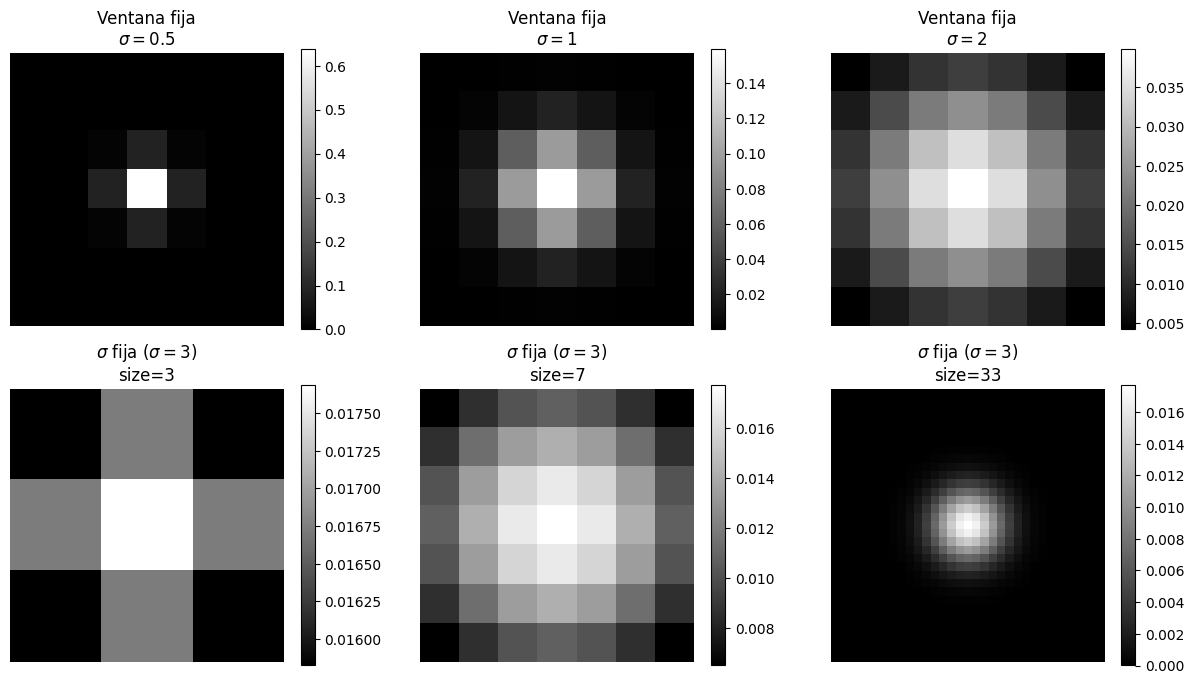

In [11]:
# Visualización 2D de múltiples filtros gaussianos

plt.figure(figsize=(15, 8))

plt.subplot(231)
plt.title("Ventana fija\n" + r"$\sigma=0.5$")
_, _, g1 = gaussian_kernel(7, 0.5)
plt.imshow(g1, cmap='gray')
plt.axis('Off')
plt.colorbar()

plt.subplot(232)
plt.title("Ventana fija\n" + r"$\sigma=1$")
_, _, g2 = gaussian_kernel(7, 1)
plt.imshow(g2, cmap='gray')
plt.axis('Off')
plt.colorbar()

plt.subplot(233)
plt.title("Ventana fija\n" + r"$\sigma=2$")
_, _, g3 = gaussian_kernel(7, 2)
plt.imshow(g3, cmap='gray')
plt.axis('Off')
plt.colorbar()

plt.subplot(234)
plt.title("$\sigma$ fija ($\sigma = 3$)" + "\nsize=3")
_, _, g4 = gaussian_kernel(3, 3)
plt.imshow(g4, cmap='gray')
plt.axis('Off')
plt.colorbar()

plt.subplot(235)
plt.title("$\sigma$ fija ($\sigma = 3$)" + "\nsize=7")
_, _, g5 = gaussian_kernel(7, 3)
plt.imshow(g5, cmap='gray')
plt.axis('Off')
plt.colorbar()

plt.subplot(236)
plt.title("$\sigma$ fija ($\sigma = 3$)" + "\nsize=33")
_, _, g6 = gaussian_kernel(33, 3)
plt.imshow(g6, cmap='gray')
plt.axis('Off')
plt.colorbar()

Con ayuda de la figura anterior analicemos el efecto de variar el tamaño de la ventana y la desviación estándar sobre el filtro Gaussiano. En términos generales, al aumentar la varianza o el tamaño de la ventana, se le asignará un mayor peso a los píxeles circundantes al píxel central, por lo que el efecto de filtrado de ruido o suavizado será mayor. Sin embargo, estudiemos los casos límites. Note que en el caso en que $\sigma$ es muy grande con respecto al tamaño de la ventana (por ejemplo, el cuarto filtro visualizado) los pesos del filtro son aproximadamente iguales, por lo que se asemeja a un filtro de valor constante, pero el rango dinámico se vería reducido teniendo en cuenta que no considera el peso asignado a los extremos no contemplados en la ventana. Por otro lado, en el caso en que $\sigma$ es muy pequeño con respecto al tamaño de la ventana (por ejemplo, el primer y el sexto filtro visualizado), el filtro puede contemplar múltiples píxeles circundantes al píxel central. Sin embargo, muchos de estos tendrán un peso cercano a cero y por lo tanto no tendrán un efecto significativo en la intensidad asignada al píxel central en la operación de cross-correlación.


A continuación, se presenta una visualización resultante de aplicar el filtrado gaussiano sobre una imagen múltiples veces consecutivas:

(np.float64(-0.5), np.float64(549.5), np.float64(412.5), np.float64(-0.5))

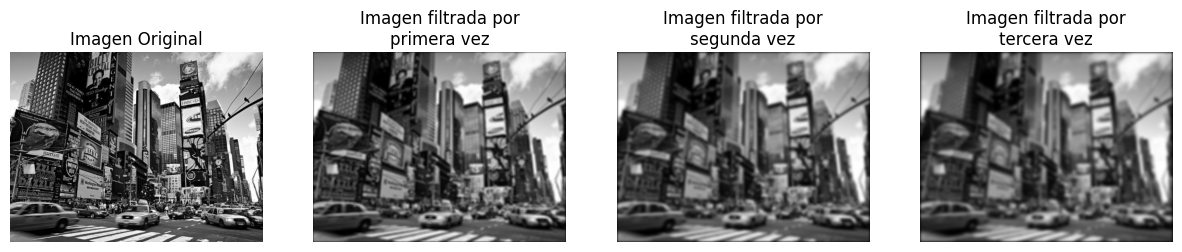

In [12]:
img = imread("wall_street.jpg", as_gray=True)
_, _, fil = gaussian_kernel(7, 3)
filtered1 = cross_correlation(img, fil)
filtered2 = cross_correlation(filtered1, fil)
filtered3 = cross_correlation(filtered2, fil)

plt.figure(figsize=(15,4))
plt.subplot(141)
plt.title("Imagen Original")
plt.imshow(img, cmap = 'gray')
plt.axis('Off')
plt.subplot(142)
plt.title("Imagen filtrada por\nprimera vez")
plt.imshow(filtered1, cmap = 'gray')
plt.axis('Off')
plt.subplot(143)
plt.title("Imagen filtrada por\nsegunda vez")
plt.imshow(filtered2, cmap = 'gray')
plt.axis('Off')
plt.subplot(144)
plt.title("Imagen filtrada por\ntercera vez")
plt.imshow(filtered3, cmap = 'gray')
plt.axis('Off')

Note que según lo estudiado en clase el filtrado gaussiano puede ser empleado para reducir el ruido de una imagen, con la desventaja de que este también hace que se pierda la definición de las pequeñas estructuras y variaciones de una imagen. Por ejemplo, en el caso anterior, note que después del filtrado consecutivo se dejan de distinguir los pájaros más alejados sobre el poste. También, las letras sobre los anuncios se vuelven ilegibles. Este *trade-off* entre eliminación del ruido y conservación de las estructuras finas de la imagen debe tenerse en cuenta en términos prácticos al emplear el filtrado gaussiano.

### **Ejercicio 2:** 
A continuacion se presenta el uso de la función matchTemplate de cv2, cuya documentacion pueden encontrar en el siguiente [enlace](https://docs.opencv.org/3.4/d4/dc6/tutorial_py_template_matching.html), para realizar la cross correlación entre una imagen y un template:

In [ ]:
def template_matching(image, template):
    '''
    res_img: Imagen resultante del template matching
    '''
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image.copy()
    
    if len(template.shape) == 3:
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    else:
        template_gray = template.copy()
    
    res_img = cv2.matchTemplate(image_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    return res_img

(np.float64(-0.5), np.float64(112.5), np.float64(126.5), np.float64(-0.5))

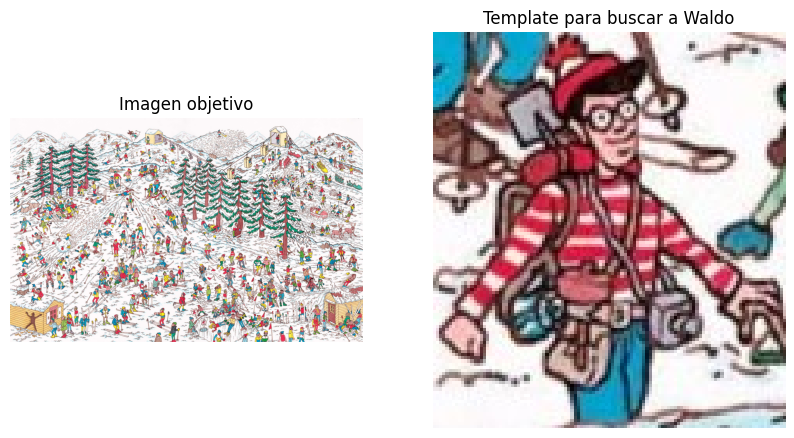

In [14]:
# Imagenes a utilizar
img = imread("Where'sWally.jpg")
template = imread("Waldo.jpg")

plt.figure(figsize=(10,10))

plt.subplot(121)
plt.title("Imagen objetivo")
plt.imshow(img)
plt.axis('off')

plt.subplot(122)
plt.title("Template para buscar a Waldo")
plt.imshow(template)
plt.axis('off')

(np.float64(-0.5), np.float64(2887.5), np.float64(1775.5), np.float64(-0.5))

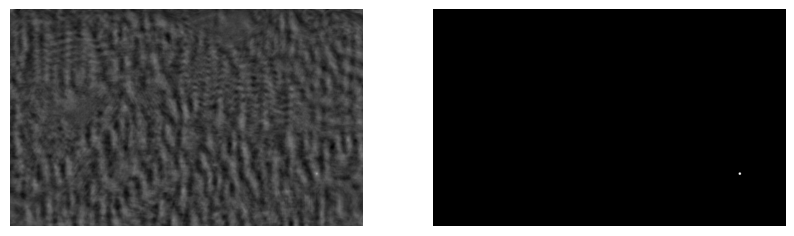

In [15]:
img_res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) 

assert(len(img_res.shape)==2)
assert(np.isclose(np.sum(img_res), -18128.95,0.01))

plt.figure(figsize=(10,10))

# Hacer plot al resultado directo de la imagen
plt.subplot(121)
plt.imshow(img_res, cmap = 'gray')
plt.axis('off')

# Hacer plot al resultado filtrando solamente el punto con mayor intensidad
img_res_max = dilation(img_res >= np.max(img_res), disk(10))

assert(np.isclose(np.sum(img_res_max), 317,0.01))

plt.subplot(122)
plt.imshow(img_res_max, cmap = 'gray')
plt.axis('off')

# Contornos

En la práctica, mediante la cross-correlación, podemos encontrar variaciones en las intensidades de una imagen en una orientación u otra. 
Un filtro que asigna pesos de signo distinto a través de un eje se conoce como filtro de diferencia finita. Un ejemplo de estos filtros son los filtros de Sobel. Hacer una cross-correlación con estos filtros es una aproximación discreta a calcular el gradiente de una imagen en dicho eje. Teniendo en cuenta que los contornos de una imagen presentan una variación local en intensidades, identificar los gradientes de la imagen a través de cross-correlaciones con filtros de diferencia finita nos permite extraer dichos contornos. Sin embargo, debido al carácter ruidoso y discontinuo de las intensidades de las imágenes, se obtienen mejores resultados al incorporar un suavizado previo mediante filtrado gaussiano.

### **Ejercicio 3:** 
A continuación, tendrá que implementar los filtros de Sobel para extraer el gradiente vertical, el gradiente horizontal. Para lo anterior, debe utilizar la función cv2.sobel la cual puede encontrar en el siguiente [enlace](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d). Posteriormente, en el código se implementará la magnitud y la dirección del gradiente de una imagen después de ser suavizada. Recuerde utilizar un kernel de tamaño 3, derivadas de orden 1 y una profundidad de entrada cv2.CV_64F.

In [16]:

# Lectura de la imagen de la que se extraerán los contornos
img_contourn = imread("prison.png", as_gray = True)
# Suavizado de la imagen mediante un filtro gausseano
_, _, fil = gaussian_kernel(7, 2)
img_filtered = cross_correlation(img_contourn, fil)

x_grad = cv2.Sobel(img_filtered, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3) # Variable que guardará el resultado de aplicar sobel en x
y_grad = cv2.Sobel(img_filtered, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3) # Variable que guardará el resultado de aplicar sobel en y

(np.float64(-0.5), np.float64(399.5), np.float64(531.5), np.float64(-0.5))

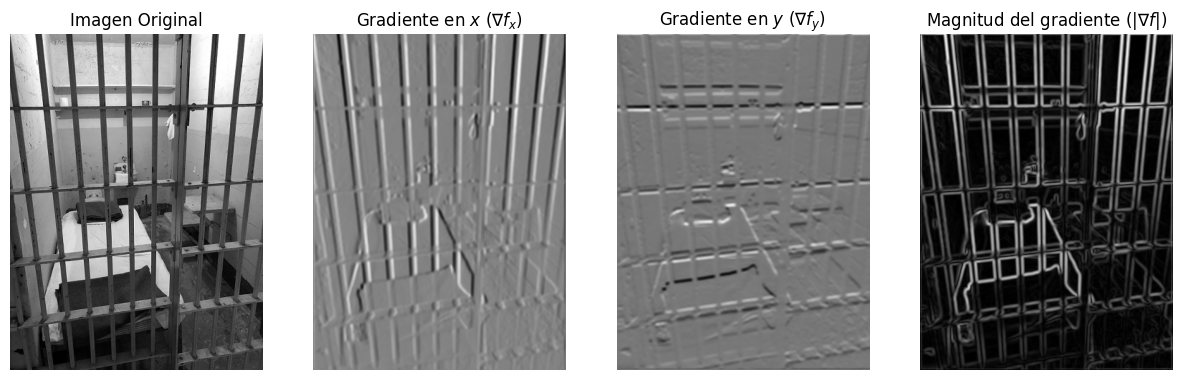

In [17]:
assert np.isclose(x_grad.min(), -1.171, 0.01) and np.isclose(x_grad.max(), 1.119, 0.01), "No se realizó el filtrado de forma correcta"
assert np.isclose(y_grad.min(), -0.976, 0.01) and np.isclose(y_grad.max(), 1.097, 0.01), "No se realizó el filtrado de forma correcta"
assert np.sum(x_grad) > 0, "No se realizó el filtrado de forma correcta"
assert np.sum(y_grad) < 0, "No se realizó el filtrado de forma correcta"


# Cálculo de la matriz asociada a la magnitud del gradiente
grad_magnitude = np.sqrt(x_grad ** 2 + y_grad ** 2)

# Cálculo de la matriz asociada a la dirección del gradiente
grad_direction = np.arctan2(y_grad, x_grad)


# Visualización
plt.figure(figsize=(15,7))

plt.subplot(141)
plt.title("Imagen Original")
plt.imshow(img_contourn, cmap='gray')
plt.axis('Off')

plt.subplot(142)
plt.title(r"Gradiente en $x$ ($\nabla f_x$)")
plt.imshow(x_grad, cmap='gray')
plt.axis('Off')

plt.subplot(143)
plt.title(r"Gradiente en $y$ ($\nabla f_y$)")
plt.imshow(y_grad, cmap='gray')
plt.axis('Off')

plt.subplot(144)
plt.title(r"Magnitud del gradiente ($|\nabla f|$)")
plt.imshow(grad_magnitude, cmap='gray')
plt.axis('Off')

Note que en la imagen de la magnitud del gradiente se pueden distinguir los contornos de la imagen con una intensidad alta. Sin embargo, note que hay bordes más anchos que otros, y la intensidad entre los bordes es variable. En algunos contextos de pre-procesamiento se espera que el ancho de los contornos sea de un píxel.

El método de Canny incorpora un proceso de supresión de no máximos para abordar este problema. En la supresión de no máximos se define una dirección de gradiente en el contorno, y se conserva únicamente el píxel con mayor intensidad en dicha dirección. A continuación, se presenta una implementación del algoritmo de supresión de no máximos:

(np.float64(-0.5), np.float64(399.5), np.float64(531.5), np.float64(-0.5))

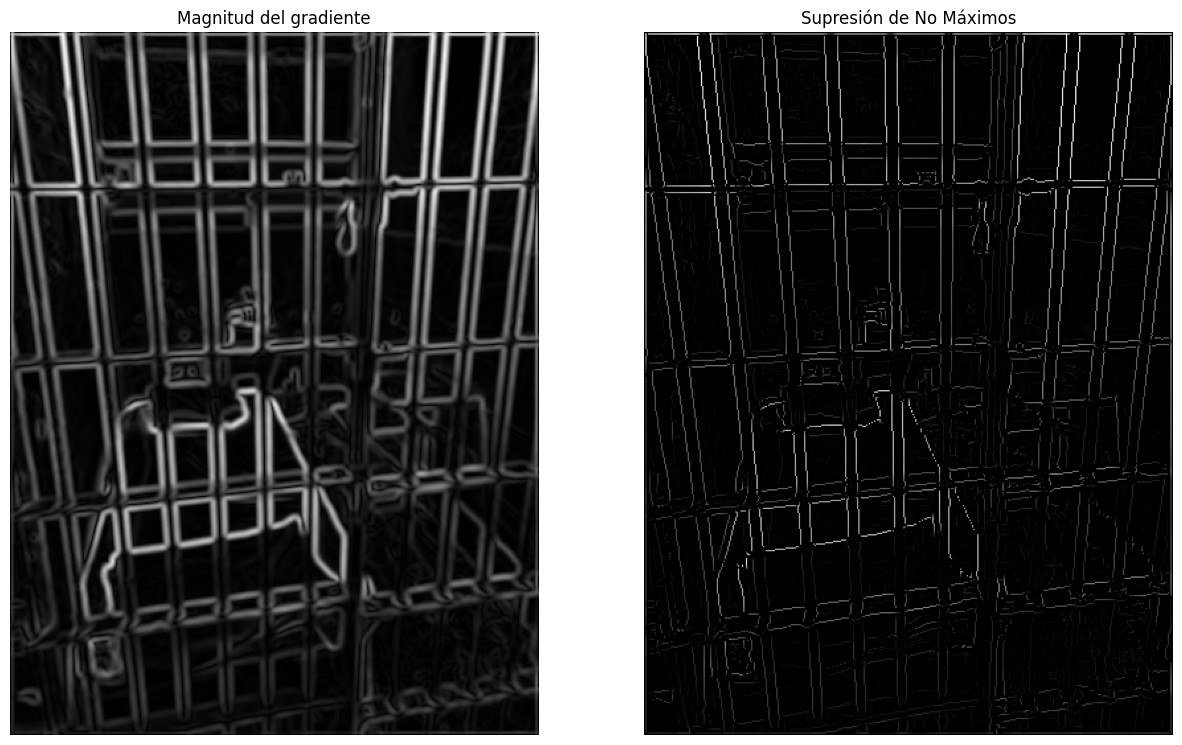

In [18]:
def non_max_supression(grad_magnitude, grad_direction):
    
    # Se crea una matriz en la que se almacenará la salida de la supresión de no máximos
    output = np.zeros(grad_magnitude.shape)
    
    # Pasamos la dirección del gradiente de radianes a grados
    grad_direction = np.rad2deg(grad_direction)

    # La función anterior retorna ángulos entre -180 y 180 grados. Para esta implementación consideraremos que gradientes
    # en direcciones antiparalelas tienen la misma orientación, por lo que sumaremos 180 grados a todos los ángulos negativos
    grad_direction[grad_direction < 0] += 180
    
    M, N = grad_magnitude.shape
 
    # En esta implementación discretarizaremos las direcciones del gradiente, y consideraremos 4 posibles orientaciones:
    # vertical, horizontal, y ambas diagonales. Para cada píxel (excluyendo los bordes, nótelo en los índices del ciclo)
    # clasificaremos la orientación del gradiente en estas 4 direcciones según su crecanía a los 0, 45, 90 y 180 grados.
    # Posteriormente, almacenaremos las intensidades de los píxeles adyacentes en esta dirección en las variables q y r.
    # Si la intensidad del píxel analizado es mayor a q y r es un máximo del gradiente en esta dirección, y por lo tanto
    # será asignado a la matriz a retornarse. De lo contrario se asignará una intensidad de 0.
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            p = 255
            r = 255

           #angle 0
            if (0 <= grad_direction[i,j] < 22.5) or (157.5 <= grad_direction[i,j] <= 180):
                p = grad_magnitude[i, j+1]
                r = grad_magnitude[i, j-1]
            #angle 45
            elif (22.5 <= grad_direction[i,j] < 67.5):
                p = grad_magnitude[i+1, j-1]
                r = grad_magnitude[i-1, j+1]
            #angle 90
            elif (67.5 <= grad_direction[i,j] < 112.5):
                p = grad_magnitude[i+1, j]
                r = grad_magnitude[i-1, j]
            #angle 135
            elif (112.5 <= grad_direction[i,j] < 157.5):
                p = grad_magnitude[i-1, j-1]
                r = grad_magnitude[i+1, j+1]

            if (grad_magnitude[i,j] >= p) and (grad_magnitude[i,j] >= r):
                output[i,j] = grad_magnitude[i,j]
            else:
                output[i,j] = 0

    return output

# Visualización

nms_image = non_max_supression(grad_magnitude, grad_direction)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Magnitud del gradiente")
plt.imshow(grad_magnitude, cmap='gray')
plt.axis('Off')
plt.subplot(122)
plt.title("Supresión de No Máximos")
plt.imshow(nms_image, cmap='gray')
plt.axis('Off')

Si bien la supresión de no máximos soluciona el problema de asignar un mismo grosor de un píxel a todos los contornos, note que las intensidades entre contornos varían, y existen diferencias en el gradiente de intensidad intermedia que pueden o no pertenecer a los contornos relevantes de la imagen. Para solucionar este problema, el método de Canny emplea una doble umbralización y un proceso de histéresis. 

En la doble umbralización se define un umbral superior y un umbral inferior. Los pixeles con una intensidad de gradiente mayor al umbral superior son considerados como bordes fuertes, mientras que los pixeles con una intensidad de gradiente menor al umbral inferior son descartados como candidatos a ser bordes. Aquellos pixeles cuya intensidad de gradiente se encuentre entre estos dos umbrales son considerados como bordes débiles. La histéresis permite identificar si los bordes débiles son adyacentes a los bordes fuertes, y por lo tanto deben ser considerados como parte del contorno de la imagen. La histéresis consiste en transformar los bordes débiles en bordes fuertes si y solo si algún píxel en una vecindad del borde débil pertenece a un borde fuerte. A continuación, se presenta una implementación de la doble umbralización e histéresis:

(np.float64(-0.5), np.float64(399.5), np.float64(531.5), np.float64(-0.5))

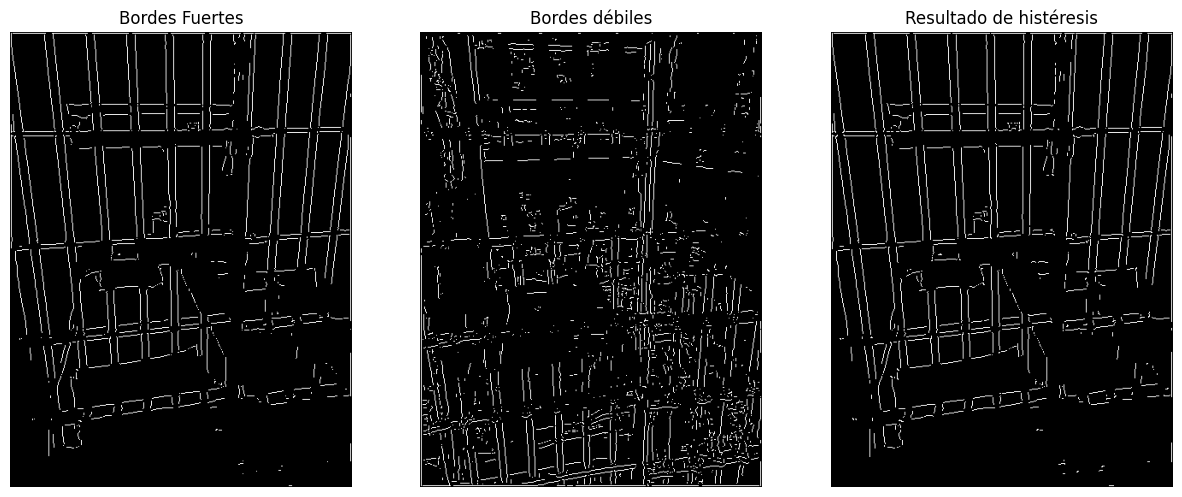

In [19]:
# Se definen los umbrales superior e inferior
thr_sup = 0.3
thr_inf = 0.05

# Se definen los bordes fuertes como aquellos con intensidades mayores al umbral superior
strong_borders = (nms_image > thr_sup).astype(int)

# Se definen los bordes débiles como aquellos entre ambos umbrales
weak_borders = np.ones(nms_image.shape, dtype=int) * (nms_image < thr_sup) * (nms_image > thr_inf)

def hysteresis(strong_borders, weak_borders):
    
    # La imagen a retornar se inicializa como una copia de los bordes fuertes
    output = strong_borders.copy()
    
    M, N = strong_borders.shape
    
    # Para cada píxel a excepción de la frontera:
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            
            # Si es un borde débil, revisar si en sus píxeles adyacentes hay un borde fuerte. Esto se hace sumando
            # los elementos de una matriz 3x3 centrada en el píxel a revisar en la imagen de bordes fuertes.
            # Si la suma es mayor a 0, hay un borde fuerte en la vecindad y por lo tanto se asigna el valor de 1
            # en la imagen a retornar
            if weak_borders[i, j] == 1:
                adjacent_strong = strong_borders[i-1:i+2, j-1:j+2]
                if np.sum(adjacent_strong) > 0:
                    output[i, j] = 1
    return output

# Visualización
final_canny = hysteresis(strong_borders, weak_borders)

plt.figure(figsize=(15,6))
plt.subplot(131)
plt.title("Bordes Fuertes")
plt.imshow(strong_borders, cmap='gray')
plt.axis('Off')

plt.subplot(132)
plt.title("Bordes débiles")
plt.imshow(weak_borders, cmap='gray')
plt.axis('Off')

plt.subplot(133)
plt.title("Resultado de histéresis")
plt.imshow(final_canny, cmap='gray')
plt.axis('Off')

En resumen, el método de detección de bordes de Canny, el cual desarrollamos a lo largo de esta sección consiste de los siguientes pasos:

1. Suavizado de la imagen mediante filtrado gaussiano.
1. Obtención de la magnitud y dirección del gradiente de la imagen a partir de cross-correlación con filtros de diferencias finitas (por ejemplo, filtros de Sobel).
1. Supresión de no máximos.
1. Doble umbralización.
1. Histéresis.

### Creditos:
Danniel Moreno - Juan Camilo Lyons - Javier Santiago Vera Rincon - Felipe Escallón Páez - Jose Miguel Abril Nova